## MAP Lab

**Exercise**

Let's compare the Ridge regression to the full baysian model from Project 4 (tide example)

1. Plot the data points, the Baysian Regression Line and the Ridge Regression Line in one plot. Can you observe any difference? Discuss your result. 
2. The Ridge Regression makes prediction by taking the decision based upon the value of the Ridge Regression Line.
For a fixed time t that uou can choose (for example t =5) calculate the integrate error rate (loss) between the Baysian Approach and the Ridge Regression. Discuss your pick of loss function.

In [59]:
from scipy.special import binom, beta, gamma
from scipy.optimize import minimize
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.special import gamma
from math import log
import emcee
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import corner
import collections
%matplotlib inline

class Bayes_Watch(object):
    """Accepts four arguments: Atom log likelihood, prior log, input data, number of walkers (must be even), 
    number of steps, vertical offset of the MCMC and list of variables."""
    def __init__(self, atom, prior, data, walkers, steps, vertical_offset, variable_names):
        atom_log = atom
        prior_log = prior
        likelihood_log = lambda x: np.sum([atom_log(x)(e) for e in self.data])
        lnprob = lambda x: likelihood_log(x) + prior_log(x)
        self.data = data
        self.steps = steps
        self.walkers = walkers
        self.variable_names = variable_names
        self.parameter_values_w_labels = []
        self.parameter_values = []
        self.vertical_offset = vertical_offset
        
        #Monte Carlo for predictive distribution
        self.MonteCarlo = lambda f: 1/float(len(self.samples))*sum([f(e) for e in self.samples])

        #Run markov chain monte carlo
        p0 = np.random.rand(self.walkers*len(self.variable_names))\
             .reshape((self.walkers,len(self.variable_names)))*self.vertical_offset
        self.sampler = emcee.EnsembleSampler(self.walkers, len(self.variable_names), lnprob)
        pos, prob, state = self.sampler.run_mcmc(p0, 1000)
        self.sampler.reset()
        pos, prob, state = self.sampler.run_mcmc(pos, self.steps)
        self.samples = self.sampler.flatchain
        print ('init and mcmc complete.')
    
    def estimate_model_parameters(self):
        '''Call using () to set values of model parameters'''
        self.parameter_values = self.MonteCarlo(lambda x: x)
        self.parameter_values_w_labels = zip(self.variable_names, self.parameter_values)
        return self.parameter_values_w_labels
    
    def plot_scatter(self, title = 'Data scatter plot', x_label = 'x', y_label = 'y'):
        '''Create a scatter plot of data. Title="Regression over data"; x_label="x"; y_label="y"'''
        X = [x[0] for x in self.data]
        T = [x[1] for x in self.data]
        fig, ax = plt.subplots(1,1, figsize = (5,3))
        ax.scatter(T,X)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.legend(loc = 'best', fontsize='small')
        ax.grid()
        
    def plot_regression(self, regression, reg_plot_range=(-20,20), \
                        title = 'Regression over data', x_label = 'x', y_label = 'y'):
        '''Create a scatter plot of data and regression line. Regression formula; reg_plot_range=(-20,20); 
        Title="Regression over data"; x_label="x"; y_label="y"'''
        self.Xval = np.arange(reg_plot_range[0],reg_plot_range[1],0.01) 
        self.Reg = np.array([regression(x)(self.parameter_values) for x in self.Xval])
        X = [x[0] for x in self.data]
        T = [x[1] for x in self.data]
        fig, ax = plt.subplots(1,1, figsize = (5,3))
        ax.scatter(T,X)
        ax.plot(self.Xval, self.Reg, label = title, color = 'red')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.legend(loc = 'best', fontsize='small')
        ax.grid()

    def plot_probability_density(self):
        sample_data = pd.DataFrame(self.samples, columns =[self.variable_names[0], self.variable_names[1], 
                                                           self.variable_names[2], self.variable_names[3]])
        sample_data.plot(kind = 'density')

    def predict_distribution(self, time, func, title="Predictive Distribution"):
        '''Plots prediction distribution around a user-specified time. Inputs: self; time (float); function; 
           title="Predictive Distribution".'''
        self.title = title
        self.time = time
        self.func = func
        predictiveDist = lambda x: np.vectorize(lambda t: self.MonteCarlo(lambda d: self.func(t,x)(d)))
        Xval = np.arange(0,25)
        plt.plot(Xval,predictiveDist(self.time)(Xval))
        plt.title(self.title)
    
    def plot_corner(self):
        fig = corner.corner(self.samples, labels=self.variable_names)


In [60]:
data = [(12.676817787115283, 4.840968499185621),
 (3.0635215093963133, 3.14922059397124),
 (8.9357879700357667, 5.431164887988198),
 (13.150389074317657, 0.2734372074578954),
 (12.925121692101902, 5.02106046462978),
 (10.269853674176913, 3.7776881451798454),
 (8.5618490817719284, 1.7531496843623315),
 (11.652310665546354, 0.13740741237008774),
 (15.785676964359141, 0.1589401373556326),
 (10.709910995988764, 1.405806821770987),
 (7.1341191045745171, 5.791539306670335),
 (21.883583042704814, 5.375575646320319),
 (9.3509495831601566, 1.5283167578387404),
 (8.9421204746670746, 1.2943521169392636),
 (7.9107785943448947, 2.41326855106268),
 (6.6761875778137583, 5.605375440538395),
 (11.650996974527924, 4.935997586415922),
 (17.290020321649969, 5.274010438371379),
 (13.06634684581484, 0.2347909715055829),
 (9.2602800850011402, 1.9716673533870746),
 (13.919837953941261, 5.528598466510076),
 (7.9171739378319606, 5.84750784658713),
 (12.864499776009934, 0.8278490177929644),
 (10.571617689971236, 2.36723797633488),
 (15.697626403745566, 6.217581078023053),
 (6.9542139194365262, 3.1860455750181425),
 (13.120156492593505, 4.864593354788696),
 (11.454973850882114, 1.8798442605946453),
 (10.614021877252608, 0.8044135861997307),
 (7.568300166951679, 2.673290291826998),
 (10.183500038106194, 1.309623551484031),
 (13.503996786942462, 0.04020573153381622),
 (14.908454853041013, 5.049774593191907),
 (16.502324161297746, 5.406433813862234),
 (7.7831240000772652, 5.45198929005635),
 (2.7144705188261025, 4.10012261788714),
 (6.3268913726889187, 5.6611505113173575),
 (9.343465517423013, 3.2971190116581632),
 (10.029091959312348, 0.5986208146884879),
 (12.078957723820951, 0.3853462849024228),
 (12.542705834818268, 1.5820979005652125),
 (9.8489274946698337, 2.6735253975153426),
 (11.349497927312719, 1.1055955472925354),
 (11.06556939865615, 2.5611692213120962),
 (11.242786106546351, 0.6500902431293415),
 (7.5720317139333542, 3.4428084142928075),
 (10.19301456907124, 2.427329872753534),
 (11.688185995125892, 0.14941531339444405),
 (13.321217017544326, 4.226862591173392),
 (9.2226853401109601, 2.3990630763955374),
 (7.0737562512314449, 0.8821159241146929),
 (5.5158907409668556, 2.287657630597947),
 (5.2424711689478309, 3.4418528431658317),
 (11.826235109408199, 3.3038133315910185),
 (6.2478202112864949, 3.7493402648869223),
 (7.2776616254733053, 2.666108760536187),
 (14.728663233221567, 5.923646379789856),
 (11.088563226667782, 2.974838497958867),
 (11.458847468046265, 1.2931851555147837),
 (4.0709653063610656, 2.4390760560779694),
 (15.530850378396899, 0.7685325485891545),
 (11.615168564683962, 2.7271570577326223),
 (10.632288760396049, 5.37570954124343),
 (6.9102179020649883, 1.9530381191410195),
 (7.1344237045084675, 1.6373486764522571),
 (2.4211573415830188, 2.810112760589519),
 (7.6108111175276107, 4.181915055702122),
 (9.6538205198090434, 4.444382820070389),
 (8.1905132263562983, 3.0534156042900285),
 (7.4546566492388493, 5.388475797989607),
 (14.087818085722649, 4.961727257154151),
 (7.2780971375915371, 2.54178907740794),
 (13.49355600611988, 2.493864649506947),
 (7.1166182479555999, 3.0195450895358524),
 (13.861336288014931, 6.246482002469356),
 (9.9498449141955589, 1.5817110088866608),
 (12.090250168282912, 3.990269038499848),
 (14.0111497595614, 0.9108297343631235),
 (9.3928518482934216, 3.3950553805254793),
 (8.2709147406350212, 3.214121983305056),
 (8.386404092046515, 2.1119573572471135),
 (6.9673744914092852, 2.2083135342567983),
 (9.5162641851488523, 3.2184133097802943),
 (17.967580316152478, 3.965622119805391),
 (15.832368008468372, 0.828357131652206),
 (5.3317615928107358, 2.6644501925548774),
 (5.8971983697046877, 3.0341229253117494),
 (17.963906775041007, 6.0469989006758444),
 (5.6300726881847361, 2.4077579346402826),
 (11.348534324413565, 3.8699231013565725),
 (10.028167958705753, 1.9397974132848168),
 (14.062219131934697, 4.41603067403343),
 (9.10707255345568, 0.8011371320017451),
 (10.567716164156263, 4.450436137829604),
 (10.928830310193101, 4.839816330906595),
 (11.681478622619728, 0.8572196990559613),
 (11.538949263967641, 5.760338188965996),
 (10.978084516398958, 4.49756314191279),
 (12.818751132975834, 4.411544813273495),
 (6.7181748281785731, 5.484421751460473)]

In [61]:
#model - takes prior log, likelihood log, - data and model parameters
prior_log = lambda x: -0.5 * (x[0]**2 + x[1]**2 + x[2]**2 ) - x[3] 

variables = ['Omega0', 'Omega1', 'Omega2', 'Lambda']

regression = lambda t: lambda m: m[0] + m[1]*np.sin(t) + m[2]*np.cos(t)

atom_log = lambda x: lambda e: -np.infty if x[3] < 0 else 0.5 * np.log(x[3])-(x[3]/2)*\
                                (e[0]-(x[0]+x[1]*np.sin(e[1]) + x[2] * np.cos(e[1])))**2

tides_run1 = Bayes_Watch(atom_log, prior_log, data, 20, 1000, 10, variables)


init and mcmc complete.


In [62]:
tides_run1.estimate_model_parameters()

[('Omega0', 9.44833504362159),
 ('Omega1', -0.58343294841915805),
 ('Omega2', 1.8053363189692384),
 ('Lambda', 0.096382268367299864)]

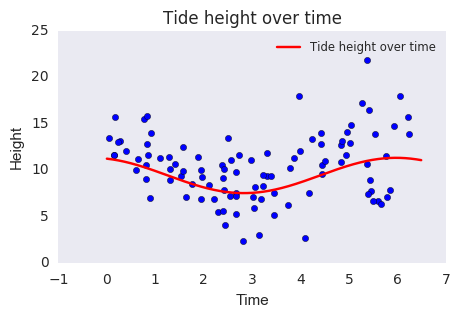

In [63]:
tides_run1.plot_regression(regression,(0,6.5),'Tide height over time',"Time","Height")

[ 10.40028096  -0.7975271    2.15536657]


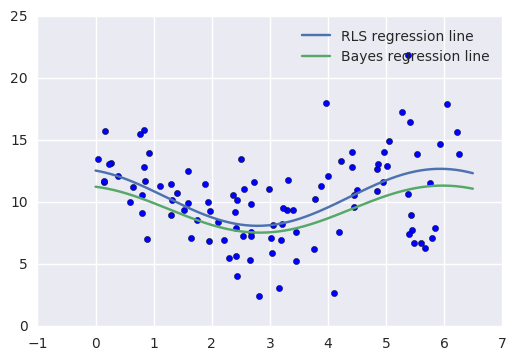

In [91]:
RLS = lambda w, b: 0.5*np.sum([(d[0] -(w[0]+w[1]*np.sin(d[1]) + w[2]*np.cos(d[1])))**2 for d in data])\
                              + 0.5*b*np.sum([e**2 for e in w])
b = 1
minRLS = minimize(lambda w: RLS(w,b),[0,0,0])
print minRLS.x
X = [x[0] for x in data]
T = [x[1] for x in data]
T1 = np.arange(0,6.5,0.01)
RichRegLine = np.vectorize(lambda t: minRLS.x[0] + minRLS.x[1]*np.sin(t) + minRLS.x[2]*np.cos(t))
Bayes_regression = lambda t: lambda m: m[0] + m[1]*np.sin(t) + m[2]*np.cos(t)
plt.scatter(T,X)
plt.plot(T1,RichRegLine(T1),label = 'RLS regression line')
plt.plot(T1, Bayes_regression(T1)(tides_run1.parameter_values),label='Bayes regression line')
plt.legend()

In [74]:
max_post = lambda t: minRLS.x[0] + minRLS.x[1]*np.sin(t) + minRLS.x[2]*np.cos(t)
max_post_value = max_post(5)
max_post_value

11.776445050031258

Defining our loss as the squared difference of our ridge prediction and our prediction using Bayes. 
For the estimate using Bayes, we need to take into account our prediction of Bayes. 
Use MCMC to find mu and lambda estimates.

In [92]:
x_list = []
for s in tides_run1.samples:
    x_list.append(np.random.normal(s[0] + s[1]*np.sin(5)+s[2]*np.cos(5), 1./np.sqrt(s[3])))


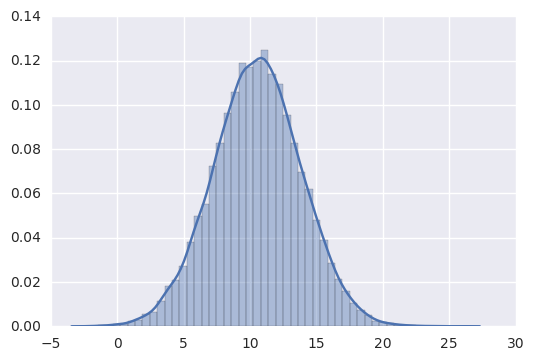

In [94]:
sns.distplot(x_list)

In [96]:
def exp_val(f, samples):
    N = len(samples)
    return 1/float(N)*sum([f(e) for e in samples])
quad_loss = lambda x : (max_post_value - x )**2
exp_val(quad_loss, x_list)

12.366177582048584

In [97]:
np.average([(max_post_value - x )**2 for x in x_list])

12.366177582048582

In [100]:
np.average(tides_run1.samples, axis = 0)

array([ 9.44833504, -0.58343295,  1.80533632,  0.09638227])